In [1]:
import torch
import torch.nn as nn
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim


# Práctica 1 - Ejercicio 2

Asignatura: Programación para la Inteligencia Artificial

Alumno: Jesús García Gaitán

Este es el segundo ejercicio de la Práctica 1 de Programación para la Inteligencia Artificial. Este ejercicio se debe entregar en un cuaderno de Jupyter separado del primero.

El objetivo es entrenar un modelo neuronal con capas lineales (MLP) para que aprenda esta imagen:
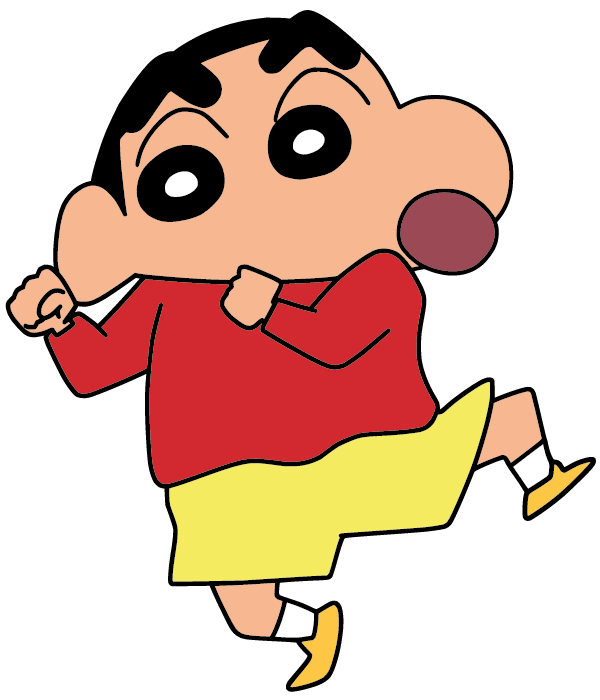

La imagen está disponible para ser descargada junto a este cuaderno (no hay que intentar extraerla del cuaderno). Para simplificar la práctica, la imagen se reducirá a un tamaño 35x30.

El modelo neuronal tiene que servir para reproducir la imagen sin necesidad de la propia imagen una vez entrenado. Se debe tener en cuenta que una imagen son colores asociados a una posición y crear un sistema en base a dicha relación.

Este problema tiene una dificultad asociada al comportamiento de los MLPs. Los MLPS son buenos aprendiendo funciones *suaves*. El problema es que una imagen es propensa a tener cambios bruscos. Por ejemplo, inmediatamente junto al color negro (\[0,0,0\] en RGB) puede ir el color blanco (\[255,255,255\] en RGB). Estas variaciones son denominamas variaciones de alta frecuencia y el MLP no es muy eficiente aprendiendo a representarlas. Para facilitar su aprendizaje podemos codificar la entrada del MLP usando una función como la siguiente que habitualmente denominamos codificación posicional (*positional encoding*):

$$\gamma(\mathbf{x})=[\gamma(x_{1}), \gamma(x_{2}),..,\gamma(x_{n})]$$ con $$\mathbf{x} \in [0,1]^n$$

$$\gamma(x_{i}) = [x_{i}, sin(2^{0}\pi x_{i}), cos(2^{0}\pi x_{i}), sin (2^{1}\pi x_{i}), cos(2^{1}\pi x_{i}),..., sin(2^{L-1}\pi x_{i}), cos(2^{L-1}\pi x_{i})]$$

Aquí está ya programado como un módulo de PyTorch :)

In [21]:
class Positional_Encoder(nn.Module):
    def __init__(self, L=10, include_input=True, device='cpu'):
        """
        Args:
            L (int): Número de frecuencias.
            include_input (bool): Si incluir la coordenada original en el output.
        """
        super(Positional_Encoder, self).__init__()
        self.include_input = include_input
        self.device = device
        self.freq_bands = 2. ** torch.linspace(0., L - 1, L, device=self.device)

    def forward(self, x):
        """
        Args:
          x (tensor): tensor de forma (..., dims) ej. (N,3) para coordenadas 3D
        """
        out = [x] if self.include_input else []
        for freq in self.freq_bands:
            out.append(torch.sin(freq * x * math.pi))
            out.append(torch.cos(freq * x * math.pi))
        return torch.cat(out, dim=-1)

    def get_output_dim(self, input_dim):
        return input_dim+2*input_dim*self.freq_bands.shape[0]

Recomiendo usarlo con los valores por defecto (L=10, include_input=True).

Intuitivamente la codificación posicional descompone los valores de entrada a una representación de la misma información en diversas frecuencias permitiendo que distintas entradas del MLP atiendan a distintos niveles de detalle.

Una vez entrenado el MLP. se requiere usarlo para generar la imagen al doble de resolución (70x60).

El cuaderno debe entregarse con los experimentos que se consideren más relevantes para resolver el problema.

El cuaderno entregado debe llamarse ApellidosNombrePractica1Ejercicio2.ipynb

Consejos:

*   Normalizar los colores de la imagen al rango [0,1].
*   Empezar trabajando con una resolución más pequeña o en escala de grises para simplificar el problema.

In [22]:
class XYDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# Loop de entrenamiento

def learning_loop(dataloader, model, epochs, loss_fn, learning_rate, optimizer):
  epoch_loss_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  for epoch in tqdm(range(epochs), desc="epoch:"):
    step_loss_list = []
    for x_true, y_true in dataloader:
      y_pred = model(x_true)                              # Forward
      opt.zero_grad()
      loss = loss_fn(y_pred, y_true)
      loss.backward()                                     # Backward
      step_loss_list.append(loss.clone().detach())
      opt.step()
    epoch_loss_list.append(torch.tensor(step_loss_list).mean())

  return model, epoch_loss_list


### Gestión de la imagen, normalización y representación

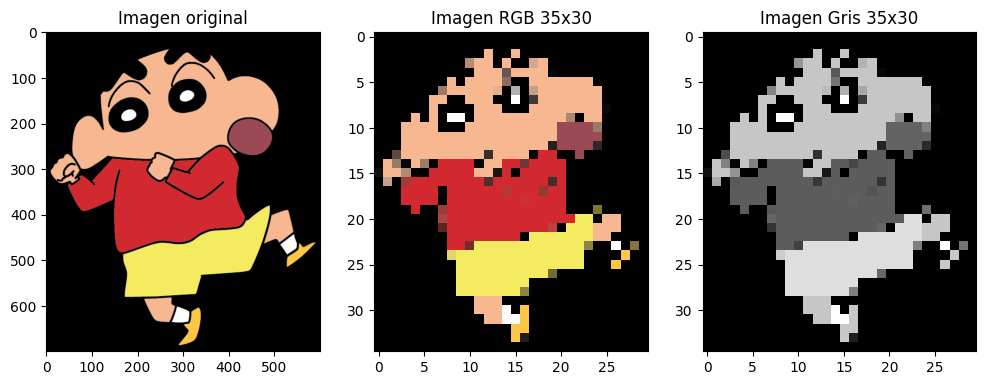

In [ ]:
plt.figure(figsize=(12, 8))

img_rbg = cv2.imread("shin_chan_progIA.png", cv2.IMREAD_COLOR_RGB)
plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(img_rbg)

img_rgb_resized = cv2.resize(img_rbg, [30, 35])
plt.subplot(1,3,2)
plt.title("Imagen RGB 35x30")
plt.imshow(img_rgb_resized)


img_gray = cv2.cvtColor(img_rbg, cv2.COLOR_RGB2GRAY)
img_gray_resized = cv2.resize(img_gray, [30, 35])
plt.subplot(1,3,3)
plt.title("Imagen Gris 35x30")
plt.imshow(img_gray_resized, cmap='gray')

img_rgb_normalized = img_rgb_resized.astype(np.float32) / 255.0
img_gray_normalized = img_gray_resized.astype(np.float32) / 255.0





### Entrenamiento del modelo MLP con la imagen en escala de grises

epoch:: 100%|██████████| 3000/3000 [04:29<00:00, 11.14it/s]


Error absoluto medio: 0.0572


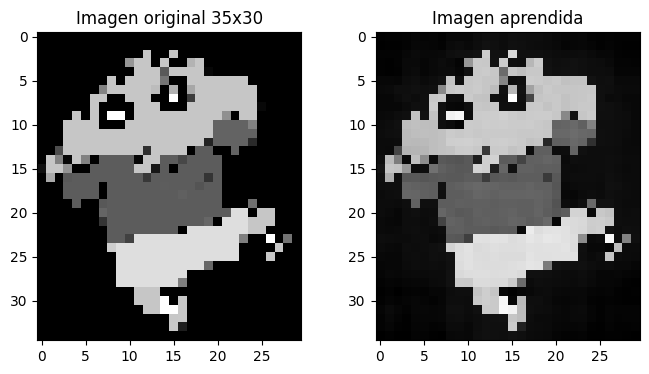

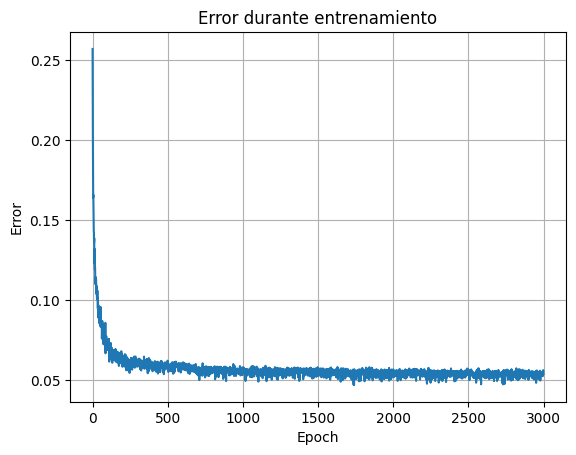

In [24]:
# Reconstrucción

H, W = img_gray_resized.shape
xs = torch.linspace(0,1,W)
ys = torch.linspace(0,1,H)
coordsx, coordsy = torch.meshgrid(
                            xs, 
                            ys, 
                            indexing='xy')
coords = torch.stack([coordsx, coordsy], dim=-1).reshape(-1,2)

encoderGray = Positional_Encoder(L=5)
gray_coords_enc = encoderGray(coords)
gray_ints = torch.from_numpy(img_gray_normalized).reshape(-1,1)

dataset = XYDataset(gray_coords_enc, gray_ints)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


# Modelo MLP

input_dim = encoderGray.get_output_dim(2)
model = nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.LeakyReLU(),
    nn.Linear(256 , 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 1),
)


epochs = 3000
learning_rate = 1e-1
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD



model, losses = learning_loop(train_loader, model, epochs, loss_fn, learning_rate, optimizer)


img_gray_pred = model(gray_coords_enc).reshape(H, W).detach().numpy()

mean_error = sum(losses) / len(losses)
print(f"Error absoluto medio: {mean_error:.4f}")


# PLOTS

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Imagen original 35x30")
plt.imshow(img_gray_normalized, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Imagen aprendida")
plt.imshow(img_gray_pred, cmap='gray')
plt.show()

plt.figure()
plt.plot(losses)
plt.title("Error durante entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.grid(True)
plt.show()



Estamos entrenando el modelo para que aprenda la imagen de Shin Chan en blanco y negro. El objetivo es que la red neuronal sea capaz de dibujar la imagen por sí sola, solo sabiendo la posición de cada píxel. Después de entrenar durante 3000 épocas, el modelo consigue un error absoluto medio de 0.0572, manteniendo un error bastante bajo durante gran parte del entrenamiento. La imagen que ha aprendido se parece mucho a la original demostrando que el modelo ha sido capaz de entender la imagen.

### Reconstrucción de la imagen en escala de grises a 70x60 píxeles con el modelo MLP

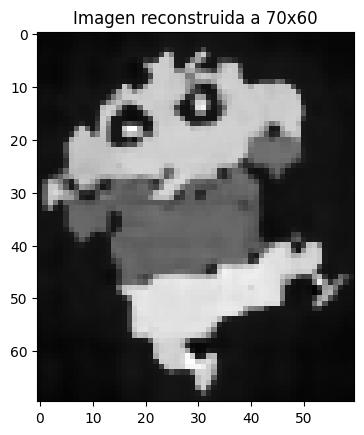

In [25]:
# Ampliar resolución

H = 70
W = 60
xs = torch.linspace(0,1,W)
ys = torch.linspace(0,1,H)
coordsx, coordsy = torch.meshgrid(
                            xs, 
                            ys, 
                            indexing='xy')
coords = torch.stack([coordsx, coordsy], dim=-1).reshape(-1,2)

gray_highres_coords_enc = encoderGray(coords)


with torch.no_grad():
    img_gray_highres = model(gray_highres_coords_enc).cpu().numpy().reshape(H, W, 1)



plt.figure()
plt.title("Imagen reconstruida a 70x60")
plt.imshow(img_gray_highres, cmap='gray')
plt.show()

Usamos el modelo ya entrenado para generar una imagen más grande con el doble de resolución. Esto pone a prueba si el modelo realmente entendió cómo se dibuja la imagen de Shin Chan. El resultado es bastante bueno. La imagen que ha sido generada es coherente y aunque sigue viéndose algo borrosa, mantiene la forma, salvo en ciertos lugares en los que al haber poca información debido a la baja cantidad de píxeles, no se consigue representar de forma tan exacta, como por ejemplo la pierna izquierda que en la imagen de 30x35 solo está representada con un píxel. Podemos asegurar que la red aprendió los patrones y es capaz de "inventar" los píxeles que faltan para crear una imagen más grande.

### Entrenamiento del modelo MLP con la imagen a color

epoch::   0%|          | 0/3000 [00:00<?, ?it/s]

epoch:: 100%|██████████| 3000/3000 [04:34<00:00, 10.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031325866..1.0337644].


Error absoluto medio: 0.0234


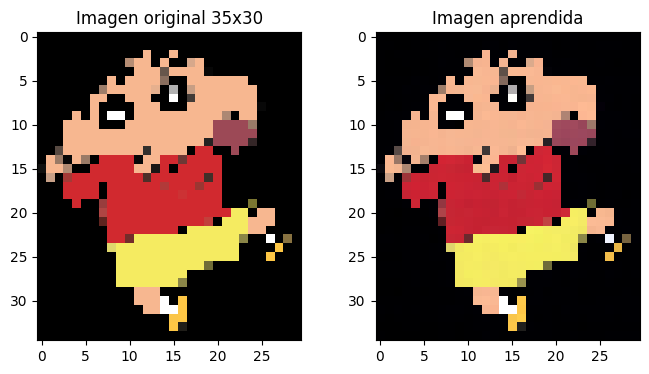

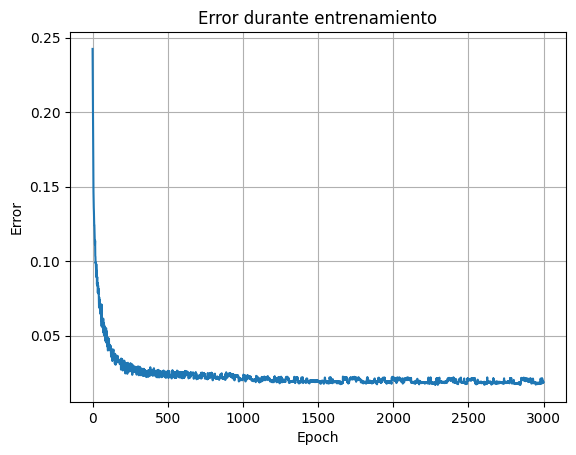

In [26]:
# Reconstrucción

H, W , color = img_rgb_resized.shape
xs = torch.linspace(0,1,W)
ys = torch.linspace(0,1,H)
coordsx, coordsy = torch.meshgrid(
                            xs, 
                            ys, 
                            indexing='xy')
coords = torch.stack([coordsx, coordsy], dim=-1).reshape(-1,2)

encoder = Positional_Encoder(L=5)
coords_enc = encoder(coords)
rgb_ints = torch.from_numpy(img_rgb_normalized).reshape(-1,3)

dataset = XYDataset(coords_enc, rgb_ints)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


# Modelo MLP

input_dim = encoder.get_output_dim(2)
model = nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.LeakyReLU(),
    nn.Linear(256 , 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 3),
)


epochs = 3000
learning_rate = 1e-1
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD



model, losses = learning_loop(train_loader, model, epochs, loss_fn, learning_rate, optimizer)


img_rgb_pred = model(coords_enc).reshape(H, W, 3).detach().numpy()

mean_error = sum(losses) / len(losses)
print(f"Error absoluto medio: {mean_error:.4f}")


# PLOTS

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Imagen original 35x30")
plt.imshow(img_rgb_normalized, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Imagen aprendida")
plt.imshow(img_rgb_pred, cmap='gray')
plt.show()

plt.figure()
plt.plot(losses)
plt.title("Error durante entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.grid(True)
plt.show()



Ahora sí, tenemos lo mismo pero con la imagen a color, lo cual es más difícil porque ahora el modelo tiene que aprender tres valores (rojo, verde y azul) para cada píxel en lugar de solo uno. A pesar de la mayor complejidad, el modelo lo hace muy bien, consiguiendo un error absoluto medio de solo 0.0234. Este error tan bajo nos dice que los colores que ha aprendido son muy parecidos a los de la imagen original y que, visualmente, la imagen aprendida es casi idéntica a la original de 35x30.

### Reconstrucción de la imagen en color a 70x60 píxeles con el modelo MLP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04644948..1.1009207].


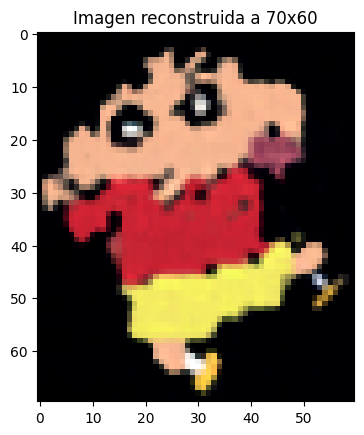

In [27]:
# Ampliar resolución

H = 70
W = 60
xs = torch.linspace(0,1,W)
ys = torch.linspace(0,1,H)
coordsx, coordsy = torch.meshgrid(
                            xs, 
                            ys, 
                            indexing='xy')
coords = torch.stack([coordsx, coordsy], dim=-1).reshape(-1,2)

coords_enc = encoder(coords)


with torch.no_grad():
    img_rgb_highres = model(coords_enc).cpu().numpy().reshape(H, W, 3)



plt.figure()
plt.title("Imagen reconstruida a 70x60")
plt.imshow(img_rgb_highres)
plt.show()

Finalmente, volvemos a reconstruir la imagen a 70x60 como ya hicimos anteriomente pero ahora con el modelo entrenado con la imagen a color. De nuevo, el resultado es bueno. La red neuronal dibuja una versión más grande de nuestra imagen que se ve muy bien, con los colores y las formas correctas al igual que la imagen en gris. Esto nos confirma que el modelo ha aprendido a generalizar muy bien teniendo incluso la complejidad del color.

### Resumen de todas las imágenes generadas

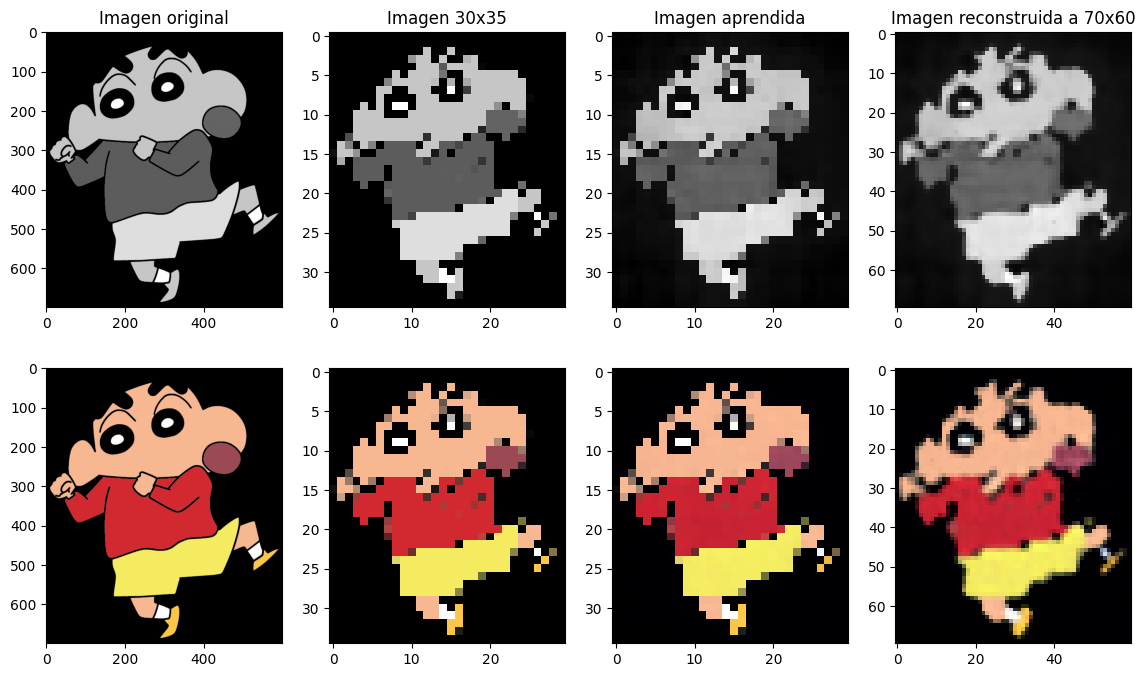

In [28]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 4, 1)
plt.title("Imagen original")
plt.imshow(img_gray, cmap='gray')

plt.subplot(2, 4, 2)
plt.title("Imagen 30x35")
plt.imshow(img_gray_resized, cmap='gray')

plt.subplot(2, 4, 3)
plt.title("Imagen aprendida")
plt.imshow(img_gray_pred, cmap='gray')

plt.subplot(2, 4, 4)
plt.title("Imagen reconstruida a 70x60")
plt.imshow(img_gray_highres, cmap='gray')

plt.subplot(2, 4, 5)
plt.imshow(img_rbg)

plt.subplot(2, 4, 6)
plt.imshow(img_rgb_resized)

plt.subplot(2, 4, 7)
plt.imshow(np.clip(img_rgb_pred, 0, 1))

plt.subplot(2, 4, 8)
plt.imshow(np.clip(img_rgb_highres, 0, 1))

plt.show()